# Hydraulic head change training 

## Preliminaries

In [1]:
# Imports
import importlib
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

#ML imports
import torch
import torch.nn as nn

## Custom modules
import utils.DynamicEmulator as DE
import utils.head_change_utils as utils


# Open the file and load the file
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

# Directories
simulations_path = yaml_data['simulations_path']
inp_path =  yaml_data['inp_path']
rain_path = simulations_path + '\\block' + '\\block.dat'
heads_path = simulations_path + '\\block' + '\\rainblock_head_TuindorpRP.pk'

## Read data from rainfall and hydraulic head

In [2]:
#Rainfall
rainfall_raw_data = utils.get_rain_in_pandas(rain_path)

#Hydraulic head
head_raw_data = utils.get_info_from_pickle(heads_path)
head_raw_data.columns = head_raw_data.columns.str.replace("_Hydraulic_head", "")
head_raw_data.columns = head_raw_data.columns.str.replace("node_", "")

In [3]:
#Periods without rain
# dry_periods_index = rainfall_raw_data[rainfall_raw_data['value']==0].index
dry_periods_index = [[12, 13, 14, 15, 16, 17],          #First dry period
                     [24, 25, 26, 27, 28, 29, 30, 31,], #Second dry period
                     [38, 39, 40, 41, 42, 43, 44, 45],  #Third dry period
                     [52, 53, 54, 55, 56, 57],          #Fourth dry period
                     [64, 65, 66, 67, 68, 69],          #Fifth dry period
                     [76, 77, 78, 79, 80, 81, 82, 83, 84] #Last dry period
                    ]

In [4]:
h0_values = []
h1_values = []

for dry_period in dry_periods_index:
    heads_no_rain = head_raw_data.iloc[list(dry_period), :]
    initial_heads, next_heads = utils.get_h0_h1_couples(heads_no_rain)
    
    h0_values.extend(initial_heads)
    h1_values.extend(next_heads)


## Separate samples in training/validation/testing

In [5]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(h0_values, h1_values,
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

## Data preprocessing

### Normalization

In [6]:
max, min = utils.get_max_and_min(X_train + y_train) #It considers all heads with the same scaling

normalized_x = utils.normalize_sample_values(X_train, max, min)
normalized_y = utils.normalize_sample_values(y_train, max, min)

### Visualization

In [7]:
# For a single node
single_node_x = []
single_node_y = []
node_name = 'j_90492'
length_database = len(normalized_x) #same as y_train

for i in range(length_database):
    single_node_x.append(normalized_x[i][node_name])
    single_node_y.append(normalized_y[i][node_name])



In [8]:
fig = go.Figure()
scatter_one_node_x_y=utils.get_scatter_trace(single_node_x, single_node_y)
fig.add_trace(scatter_one_node_x_y)

fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.update_layout(
    width = 500,
    height = 500,
    title = "%s Head changes" % (node_name)
)

fig.update_layout(
        shapes=[
            dict(
                type= 'line',
                y0= 0, 
                y1= 1, 
                x0= 0, 
                x1= 1
            )
        ])

fig.show()

## Model

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        dh = self.linear_relu_stack(x)
        return dh.flatten()

In [52]:
q_transfer_ANN = NeuralNetwork().to(device)
print(q_transfer_ANN)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [53]:
X = torch.rand(1,3, device=device)
dh = q_transfer_ANN(X)

### Model definition

In [62]:
wn = DE.DynamicEmulator(inp_path, X_train[0], q_transfer_ANN)

There are no [STORAGE]
 in the file
The file does not have pumps. A handled exception occured because of '[PUMPS]\n'
The file does not have orifices. A handled exception occured because of '[ORIFICES]\n'
The file does not have weirs. A handled exception occured because of '[WEIRS]\n'


In [63]:
#Draw graph
# wn.draw_nx_layout()

### Dynamic emulator

In [64]:
wn.set_h(X_train[0])

df = pd.DataFrame(wn.get_depths_to_pd(0), columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord'])

for time in range(100):
    wn.update_h() 
    new_h_rows = pd.DataFrame(wn.get_depths_to_pd(time+1), columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord'])
    df = pd.concat([df,new_h_rows])

[tensor(-0.0013), tensor(45.2187), tensor(0.6000)]
[tensor(-0.0749), tensor(40.2815), tensor(0.4500)]
[tensor(-0.0273), tensor(39.0932), tensor(0.4500)]
[tensor(-0.0115), tensor(36.7535), tensor(0.4500)]
[tensor(0.0627), tensor(26.3576), tensor(0.4500)]
[tensor(8.3119e-05), tensor(12.7770), tensor(0.3000)]
[tensor(0.0749), tensor(40.2815), tensor(0.4500)]
[tensor(-8.3119e-05), tensor(12.7770), tensor(0.3000)]
[tensor(-1.6779e-05), tensor(12.9256), tensor(0.3000)]
[tensor(-0.1373), tensor(45.4147), tensor(0.4500)]
[tensor(1.6779e-05), tensor(12.9256), tensor(0.3000)]
[tensor(-0.1213), tensor(12.6314), tensor(0.3000)]
[tensor(0.1373), tensor(45.4147), tensor(0.4500)]
[tensor(0.1213), tensor(12.6314), tensor(0.3000)]
[tensor(0.1448), tensor(9.6153), tensor(0.3000)]
[tensor(-0.0101), tensor(45.5219), tensor(0.4500)]
[tensor(-0.1448), tensor(9.6153), tensor(0.3000)]
[tensor(0.4578), tensor(6.5499), tensor(0.2350)]
[tensor(-0.1302), tensor(18.9762), tensor(0.3000)]
[tensor(0.0273), tensor(39

RuntimeError: stack expects each tensor to be equal size, but got [1] at entry 0 and [] at entry 1

<AxesSubplot:>

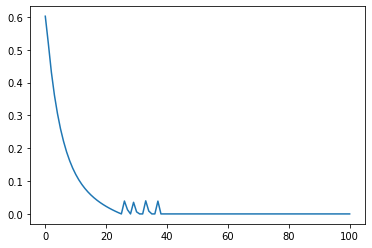

In [12]:
depth_one_node = df[df['Node']=='j_90550']['Depth']#.plot()
depth_one_node=depth_one_node.reset_index()
depth_one_node['Depth'].plot()

In [32]:
net = px.scatter(df, x="x_coord", y="y_coord", size="Depth", animation_frame="Time", size_max=20, hover_name="Node",width=500, height=800)
net.show()

In [34]:
net.write_html('Depth_dynamic_viz.html')

### Model training

### Model validation

### Model testing

## Predictions visualization

## Export model

# Scratchpad

In [61]:
importlib.reload(DE)

<module 'utils.DynamicEmulator' from 'c:\\Users\\agarzondiaz\\surfdrive\\Year 2\\Paper 2 - 3.0\\utils\\DynamicEmulator.py'>

In [24]:
a =wn.get_h()['j_9006F']

In [33]:
X

tensor([[0.7282, 0.2558, 0.6922]])

In [38]:
torch.stack([a, a, a]).view(-1,3)

tensor([[-0.2448, -0.2448, -0.2448]])